# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information, being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

Why would we want this to be a classification problem?
- While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, let's look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

In [196]:
URL = "http://www.indeed.com/jobs?as_and=data+scientist&as_phr=&as_any=&as_not=&as_ttl=&as_cmp=&jt=all&st=&salary=$20,000&radius=25&l=New+York,+NY&fromage=any&limit=100&sort=date&psf=advsrch"

In [197]:
import requests
import bs4
from bs4 import BeautifulSoup
import urllib2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [198]:

page=urllib2.urlopen(URL).read()
soup=BeautifulSoup(page, "lxml")

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element="jobTitle`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Let's write 4 functions to extract each item: location, company, job, and salary.


In [200]:
post= soup.find_all('div',class_=" row result")
post[0]

<div class=" row result" data-jk="9b0e8fe063a266d6" data-tn-component="organicJob" id="p_9b0e8fe063a266d6" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_9b0e8fe063a266d6">
<a class="turnstileLink" data-tn-element="jobTitle" href="/rc/clk?jk=9b0e8fe063a266d6&amp;fccid=3e901f592b439cea" itemprop="title" onclick="setRefineByCookie(['radius', 'salest']); return rclk(this,jobmap[0],true,1);" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="Health Scientist">Health <b>Scientist</b></a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Centers-For-Disease-Control-and-Prevention" onmousedown="this.href = appendParamsOnce(this.href, 'from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=9b0e8fe063a266d6&amp;jcid=3e901f592b439cea')" target="_blank">
        Centers for Disease Control and Prevention</a></span>
</span>

 - <a class="turns

In [201]:
def extract_jobtitle_from_result(result):
    post= result.find_all('div',class_=" row result")
    jobtitle=[]
    for i in range(len(post)):
        try:
            job=post[i].find_all("h2")[0].text
            jobtitle.append(job)
        except Exception:
            job=np.nan
            jobtitle.append(job)
    return jobtitle

In [203]:
def extract_company_from_result(result):
    post= result.find_all('div',class_=" row result")
    company=[]
    for i in range(len(post)):
        try:
            comp=post[i].find_all("span",class_="company")[0].text
            company.append(comp)
        except Exception:
            comp=np.nan
            company.append(comp)
    return company

In [205]:
def extract_location_from_result(result):
    post= result.find_all('div',class_=" row result")
    location=[]
    for i in range(len(post)):
        try:
            loc=post[i].find_all("span",class_="location")[0].text
            location.append(loc)
        except Exception:
            loc=np.nan
            location.append(loc)
    return location

In [207]:
def extract_salary_from_result(result):
    post= result.find_all('div',class_=" row result")
    salary=[]
    for i in range(len(post)):
        try:
            sal=post[i].find_all("nobr")[0].text
            salary.append(sal)
        except Exception:
            sal=np.nan
            salary.append(sal)
    return salary

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

In [209]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 3000 

results = []


cities=['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami']
for city in cities:
    for start in range(1,max_results_per_city,100):
        try:
            url="http://www.indeed.com/jobs?q=data+scientist+%%2420%%2C000&l=%s&start=%d&limit=100"%(city,start)
            print url
            page=urllib2.urlopen(url).read()
            soup=BeautifulSoup(page,"lxml")
            Company=extract_company_from_result(soup)
            Jobtitle=extract_jobtitle_from_result(soup)
            Location=extract_location_from_result(soup)
            Salary=extract_salary_from_result(soup)
            # Append to the full set of results
            results.append([Company,Jobtitle,Location,Salary])
        except Exception:
            pass


http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=1&limit=100
http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=101&limit=100
http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=201&limit=100
http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=301&limit=100
http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=401&limit=100
http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=501&limit=100
http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=601&limit=100
http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=701&limit=100
http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=801&limit=100
http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=901&limit=100
http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=1001&limit=100
http://www.indeed.com/jobs?q=data+scientist+

In [210]:
df=pd.DataFrame({"Company":results[0][0],"Jobtitle":results[0][1],"Location":results[0][2],"Salary":results[0][3]})
df.head()

,Company,Jobtitle,Location,Salary
0,\n\n Averity\n,\nMid-level Data Scientist For Top Travel Comp...,"New York, NY","$90,000 - $110,000 a year"
1,\n\n\n Federal Reserve Bank of New York\n,"\nDepartment Head, Applied Strategy - Data & S...","New York, NY",NaN
2,\n\n\n Meetup\n,\nSr. Machine Learning Engineer\n,"New York, NY 10012 (Little Italy area)",NaN
3,\n\n\n Morgan Stanley\n,\nEquity Research - Analyst Solutions Team\n,"New York, NY 10032 (Washington Heights area)",NaN
4,\n\n\n BAE Systems Applied Intelligence\n,\nAnalytics Product Manager\n,"New York, NY",NaN


In [211]:
#Let's create for each row in results a dataframe to then concatenate and form a main one

df=df=pd.DataFrame({"Company":results[0][0],"Jobtitle":results[0][1],"Location":results[0][2],"Salary":results[0][3]})

for row in results[1:]:
    df_intermediate=pd.DataFrame({"Company":row[0],"Jobtitle":row[1],"Location":row[2],"Salary":row[3]})
    df=pd.concat([df,df_intermediate])

df.head()

,Company,Jobtitle,Location,Salary
0,\n\n Averity\n,\nMid-level Data Scientist For Top Travel Comp...,"New York, NY","$90,000 - $110,000 a year"
1,\n\n\n Federal Reserve Bank of New York\n,"\nDepartment Head, Applied Strategy - Data & S...","New York, NY",NaN
2,\n\n\n Meetup\n,\nSr. Machine Learning Engineer\n,"New York, NY 10012 (Little Italy area)",NaN
3,\n\n\n Morgan Stanley\n,\nEquity Research - Analyst Solutions Team\n,"New York, NY 10032 (Washington Heights area)",NaN
4,\n\n\n BAE Systems Applied Intelligence\n,\nAnalytics Product Manager\n,"New York, NY",NaN


In [212]:
df.shape

(37192, 4)

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now
1. Some of the entries may be duplicated
1. The salaries are given as text and usually with ranges.


In [213]:

df_clean=df
df_clean=df_clean.dropna(subset=["Salary"])
df_clean.reset_index(drop=True,inplace=True)
df_clean.head()

,Company,Jobtitle,Location,Salary
0,\n\n Averity\n,\nMid-level Data Scientist For Top Travel Comp...,"New York, NY","$90,000 - $110,000 a year"
1,\n\n\n DEPT OF HEALTH/MENTAL HYGIENE\n,"\nSpecial Assistant, Bureau of Vital Statistics\n","Manhattan, NY","$59,708 - $72,246 a year"
2,\n\n\n Workbridge Associates\n,\nChief Data Scientist\n,"New York, NY","$110,000 - $140,000 a year"
3,\n\n Animalz\n,\nResearch Analyst\n,"New York, NY 10002 (Lower East Side area)","$40,000 a year"
4,\n\n Big Cloud\n,\nData Scientist\n,"New York, NY","$150,000 a year"


In [214]:
#withdrawing \n from Companies name.
df_clean["Company"]=df_clean["Company"].str.strip('\n')
df_clean.head()

/Users/dorian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Company,Jobtitle,Location,Salary
0,Averity,\nMid-level Data Scientist For Top Travel Comp...,"New York, NY","$90,000 - $110,000 a year"
1,DEPT OF HEALTH/MENTAL HYGIENE,"\nSpecial Assistant, Bureau of Vital Statistics\n","Manhattan, NY","$59,708 - $72,246 a year"
2,Workbridge Associates,\nChief Data Scientist\n,"New York, NY","$110,000 - $140,000 a year"
3,Animalz,\nResearch Analyst\n,"New York, NY 10002 (Lower East Side area)","$40,000 a year"
4,Big Cloud,\nData Scientist\n,"New York, NY","$150,000 a year"


In [215]:
#withdrawing \n from Jobtitle

df_clean["Jobtitle"]=df_clean["Jobtitle"].str.strip('\n')
df_clean.head()

/Users/dorian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Company,Jobtitle,Location,Salary
0,Averity,Mid-level Data Scientist For Top Travel Company,"New York, NY","$90,000 - $110,000 a year"
1,DEPT OF HEALTH/MENTAL HYGIENE,"Special Assistant, Bureau of Vital Statistics","Manhattan, NY","$59,708 - $72,246 a year"
2,Workbridge Associates,Chief Data Scientist,"New York, NY","$110,000 - $140,000 a year"
3,Animalz,Research Analyst,"New York, NY 10002 (Lower East Side area)","$40,000 a year"
4,Big Cloud,Data Scientist,"New York, NY","$150,000 a year"


In [216]:
df_clean.shape

(3356, 4)

In [217]:
df_clean.to_csv("indeed_wiwhout_cleaning_V2.csv", encoding="utf-8")



___

# STARTER AFTER WEB SCRAPING

In [473]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [474]:
df_clean=pd.read_csv("indeed_wiwhout_cleaning_V2.csv",thousands=",")
del df_clean["Unnamed: 0"]

df_clean.tail(10)

,Company,Jobtitle,Location,Salary
3346,University of Miami,(Temporary) Research Laboratory Technician,"Coral Gables, FL","$27,400 - $49,400 a year"
3347,University of Miami,Statistical Programmer,"Coral Gables, FL","$32,900 a year"
3348,Smith Hanley Associates,Statistical Operations Research Analyst,"Miami, FL","$75,000 - $95,000 a year"
3349,University of Miami,Research Analyst,"Coral Gables, FL","$32,900 - $59,100 a year"
3350,University of Miami,Financial Analyst (Clinical Research Revenue),"Coral Gables, FL","$38,750 - $51,000 a year"
3351,Staffing Resource Group,QC Chemist,"Miami, FL","$50,000 a year"
3352,University of Miami,Assistant Scientist/Postdoctoral Associate,"Coral Gables, FL","$53,900 - $65,000 a year"
3353,Morgan Stephens,Librarian Research Analyst,"Miami, FL","$75,000 - $85,000 a year"
3354,"Coastal Risk Consulting, LLC",Business Development Manager,"Plantation, FL","$4,000 a month"
3355,"Coastal Risk Consulting, LLC",Business Development Manager,"Plantation, FL","$4,000 a month"


In [475]:
# creating a function that returns 3 lists.
possibility=["a year","a month","an hour","-","$"]
def clean_salary(column):
    typo=[]
    range1=[]
    range2=[]
    for row in column:
        var=np.nan
        for i in range(3):
            if row.find(possibility[i])!= -1:
                var=possibility[i]
                row=row.strip(var)
        typo.append(var)
        listy=row.split(possibility[3])
        listy=[str(item).strip(' ').strip(possibility[4]) for item in listy]
        range1.append(listy[0])
        try:
            range2.append(listy[1])
        except Exception:
            range2.append("0")
    return typo,range1,range2
        

In [476]:

# creating a data frame for the salary in order to perform modelisation to a yearly rate into a range of salaries
rate, salarymax, salarymin= clean_salary(df_clean["Salary"])
Salary_df=pd.DataFrame({"Rate":rate,"Salary_max": salarymax,"Salary_min": salarymin})
df_clean=pd.concat([df_clean,Salary_df],axis=1)

# droping rate=Nan
print "There are %d rows as NaN values."%(len(df_clean)-len(df_clean["Rate"].dropna()))
df_clean=df_clean.dropna(subset=["Rate"])

df_clean.reset_index(drop=True, inplace=True)
# converting hourly rate to yearly rate= *40*52
def convert(row):
    if row[4]=="an hour":
        try:
            row[5]=float(str(row[5]))*40*52
        except Exception:
            pass
        try:
            row[6]=float(str(row[6]))*40*52
        except Exception:
            pass
    return row

df_clean=df_clean.apply(convert,axis=1)

# converting columns salary to float
df_clean["Salary_max"]=df_clean["Salary_max"].astype('str')
df_clean["Salary_max"]=df_clean["Salary_max"].str.replace(",","")
df_clean["Salary_max"]=df_clean["Salary_max"].astype('float')
df_clean["Salary_min"]=df_clean["Salary_min"].astype('str')
df_clean["Salary_min"]=df_clean["Salary_min"].str.replace(",","")
df_clean["Salary_min"]=df_clean["Salary_min"].astype('float')

print df_clean.dtypes

df_clean.head()

There are 25 rows as NaN values.
Company        object
Jobtitle       object
Location       object
Salary         object
Rate           object
Salary_max    float64
Salary_min    float64
dtype: object


,Company,Jobtitle,Location,Salary,Rate,Salary_max,Salary_min
0,Averity,Mid-level Data Scientist For Top Travel Company,"New York, NY","$90,000 - $110,000 a year",a year,90000.0,110000.0
1,DEPT OF HEALTH/MENTAL HYGIENE,"Special Assistant, Bureau of Vital Statistics","Manhattan, NY","$59,708 - $72,246 a year",a year,59708.0,72246.0
2,Workbridge Associates,Chief Data Scientist,"New York, NY","$110,000 - $140,000 a year",a year,110000.0,140000.0
3,Animalz,Research Analyst,"New York, NY 10002 (Lower East Side area)","$40,000 a year",a year,40000.0,0.0
4,Big Cloud,Data Scientist,"New York, NY","$150,000 a year",a year,150000.0,0.0


In [477]:
#Selecting the average salary per row
def average(row):
    maxi=row[5]
    mini=row[6]
    if mini==0:
        result=maxi
    else:
        result=(maxi+mini)/2
    return result
# applying the funcion to create a new column with a yearly average salary
df_clean["average salary"]=df_clean.apply(average,axis=1)
df_clean["average salary"]=df_clean["average salary"].astype('int') # only integer make sense!
#deleteting unecessary columns
todelete=["Salary","Rate","Salary_max","Salary_min"]
for col in todelete:
    del df_clean[col]
df_clean.head()

,Company,Jobtitle,Location,average salary
0,Averity,Mid-level Data Scientist For Top Travel Company,"New York, NY",100000
1,DEPT OF HEALTH/MENTAL HYGIENE,"Special Assistant, Bureau of Vital Statistics","Manhattan, NY",65977
2,Workbridge Associates,Chief Data Scientist,"New York, NY",125000
3,Animalz,Research Analyst,"New York, NY 10002 (Lower East Side area)",40000
4,Big Cloud,Data Scientist,"New York, NY",150000


In [478]:
# deleting duplicates
df_clean["average salary"]=df_clean["average salary"].astype('str')
df_clean.drop_duplicates(inplace=True)
df_clean["average salary"]=df_clean["average salary"].astype('int')

# DELETING SALARY <20000

thresh= df_clean["average salary"]>20000
df_clean=df_clean.loc[thresh,:]

#reseting index

df_clean.reset_index(drop=True, inplace=True)

Let's rearrange Job titles column so that it fits into a category.   
To this extent, we will create a function that  will act in several steps:  
- make job title as lowercase;  
- loop through the words in the job title to change some of its terms like 'chief' to 'lead', or "data"+"research" to "data scientist”;  
- create a new column that take census of the main category of the job title.

In [479]:
#dictionary for iteration
first_keywords_iteration=[["research","scientist","data scientist"],["data","research","data scientist"],\
          ["data","analytics","data scientist"],["science","scientist"],["chief","senior"],\
          ["director","senior"],["sr,","senior"],["sr.","senior"], ['sr',"senior"],["lead","senior"],\
          ['machine learning',"data scientist"],["vice president","senior"]]
          

second_keywords_iteration=[["data","scientist","senior","senior data scientist"],\
                          ["data","scientist","data scientist"]]

main_categories=["data scientist", "senior data scientist"]

def jobtitle_search(row):
    post=row.lower()
    for item in first_keywords_iteration:
        listy=[post.find(word) for word in item[:-1]]
        if min(listy)>=0:
            post=post+" "+item[-1]
    for chave in second_keywords_iteration:
        if post not in main_categories:
            listy=[post.find(mot) for mot in chave[:-1]]
            if min(listy)>=0:
                post=chave[-1]
    if post not in main_categories:
        post="other"
    return post

df_clean["reshaped_jobtitle"]=df_clean["Jobtitle"].apply(jobtitle_search)

pd.value_counts(df_clean["reshaped_jobtitle"])

other                    203
data scientist            58
senior data scientist     33
Name: reshaped_jobtitle, dtype: int64

In [480]:
# deleting other

not_other= df_clean["reshaped_jobtitle"] != "other"

df_clean=df_clean.loc[not_other,:]
df_clean.reset_index(drop=True, inplace=True)

In [481]:
# Creating a column to retrieve the state
# Also, it is well know that San Francisco as a high cost of life. Then we will create a fictif states SFCA.
def get_states(row):
    listy=str(row).strip(",")
    listy=str(listy).split(' ')
    state=""
    len_listy=[len(x) for x in listy]
    index=len_listy.index(2)
    state=listy[index]
    if state=="CA":
        if row.lower().find("san francisco")!=-1:
            state="SFCA"
    return state

In [483]:
df_clean["State"]=df_clean["Location"].apply(get_states)
pd.value_counts(df_clean["State"])

NY      31
IL      13
SFCA    11
CA      10
TX       6
GA       5
PA       5
WA       4
AZ       2
OR       1
DE       1
CO       1
NJ       1
Name: State, dtype: int64

# Save results as a CSV

In [486]:
df_clean.to_csv("indeed_cleaned.csv", encoding="utf-8")

## Predicting salaries using Logistic Regression

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Loading in the the data of scraped salaries

In [28]:

data=pd.read_csv("indeed_cleaned.csv")
del data["Unnamed: 0"]
data.head()

,Company,Jobtitle,Location,average salary,reshaped_jobtitle,State
0,Averity,Mid-level Data Scientist For Top Travel Company,"New York, NY",100000,data scientist,NY
1,Workbridge Associates,Chief Data Scientist,"New York, NY",125000,senior data scientist,NY
2,Big Cloud,Data Scientist,"New York, NY",150000,data scientist,NY
3,Workbridge Associates,Data Science Engineer,"New York, NY",165000,data scientist,NY
4,Harnham,Data Scientist - Financial Services,"New York, NY",150000,data scientist,NY


#### We want to predict a binary variable - whether the salary was low or high. We will compute the median salary and create a new binary variable that is true when the salary is high (above the median)

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choice the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries, 

In [29]:

# considering that 1 refers to a high salary, above

median_salary=np.median(data["average salary"])

data["salary_assesment"]=data["average salary"].apply(lambda x: 1 if x>=median_salary else 0)
data.head()

,Company,Jobtitle,Location,average salary,reshaped_jobtitle,State,salary_assesment
0,Averity,Mid-level Data Scientist For Top Travel Company,"New York, NY",100000,data scientist,NY,0
1,Workbridge Associates,Chief Data Scientist,"New York, NY",125000,senior data scientist,NY,0
2,Big Cloud,Data Scientist,"New York, NY",150000,data scientist,NY,1
3,Workbridge Associates,Data Science Engineer,"New York, NY",165000,data scientist,NY,1
4,Harnham,Data Scientist - Financial Services,"New York, NY",150000,data scientist,NY,1


In [30]:
# As we have states with few data, the future model of prediction can only predict random data. 
#Nevertheless, we can make the assumption they have the same cost of life, i.e same range of salary.

low_states=["AZ","OR","DE","CO","NJ"]

data["State"]=data["State"].apply(lambda x:"other" if x in low_states else x)

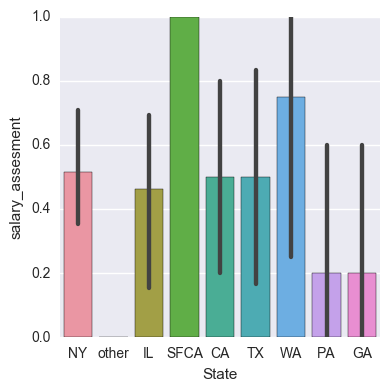

In [31]:
# logistic regression

# first let's plot a factor plot to get an idea of how a location influence the salary

sns.factorplot(x="State",y="salary_assesment",data=data,kind="bar")

sns.plt.show()

It seems every Data scientist of San Francisco will get a Salary above the median!

In [32]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.cross_validation import train_test_split,cross_val_predict,cross_val_score
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

In [33]:
# We need first to transform categorical data into dummies variable so that to perform the logistic regression

dummies_state=pd.get_dummies(data["State"])
study_1=pd.concat([data["salary_assesment"],dummies_state],axis=1)
study_1.head()

,salary_assesment,CA,GA,IL,NY,PA,SFCA,TX,WA,other
0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# Let's define our predictor X which is the whole regions and our target wich is the salary assessment
X=study_1.iloc[:,1:]
y=study_1.iloc[:,0]

logit=LogisticRegression(fit_intercept=True)
model=logit.fit(X,y)

In [35]:
#Let's look at coeficients, which represent when applying the exponential function on it, 
#the odd of getting a high salary coming from that particular region
coeff_study_1=pd.DataFrame(np.transpose(model.coef_),index=study_1.columns.values[1:],columns=["Coeff_regression"])
coeff_study_1["odds"]=coeff_study_1["Coeff_regression"].apply(np.exp)
coeff_study_1

,Coeff_regression,odds
CA,0.055184,1.056735
GA,-0.639987,0.527299
IL,-0.058719,0.942972
NY,0.125576,1.133801
PA,-0.639987,0.527299
SFCA,1.745409,5.728242
TX,0.046367,1.047459
WA,0.542733,1.720703
other,-1.253839,0.285407


As highlighted in the graph above, it confirms Data Scientist in San Francisco have a much higher salary. A data scientist in San Francisco is 6 times more likely to get a salary considered as high compared to the one in other states.

In [36]:
# This function is to plot the confusion matrix

import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

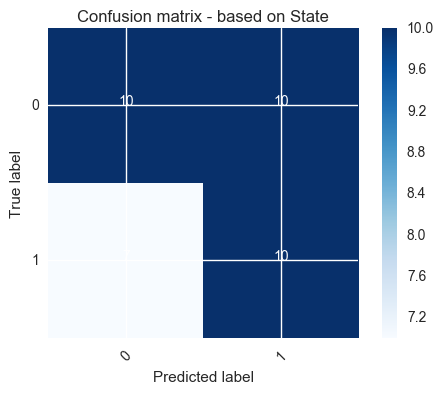

Acccuracy: 0.540540540541


In [37]:
#Let's apply now a logistic regression on a train test model
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.40, random_state=33)

logit=LogisticRegression(fit_intercept=True)
model=logit.fit(X_train,y_train)
prediction=model.predict(X_test)

conf=confusion_matrix(y_test,prediction)

plot_confusion_matrix(conf,classes=model.classes_,title='Confusion matrix - based on State')
acc=accuracy_score(y_test,prediction)
print "Acccuracy:", acc

We can  notice the accuracy is so good, probably due to the fact that our test sample is small.  
Also some regions as New York or the one we created "Other" contains various salary as there are different job positions.  

<function matplotlib.pyplot.plot>

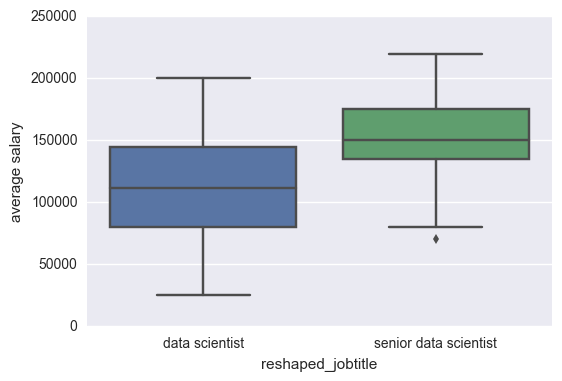

In [38]:

# Let's now look at correlation between salary and jobtitle
# Bearing in mind that we reshaped 2 jobtitles.

sns.boxplot(x="reshaped_jobtitle",y="average salary",data=data)
plt.ylim((0,250000))

sns.plt.plot

This boxplot shows us that 75% of Senior Data Scientist get a yearly salary higher than US\$ 140000 while 75% of Data Scientist from the sample get a salary lower than US$ 145000.
The accuracy will then probably be higher in that case.

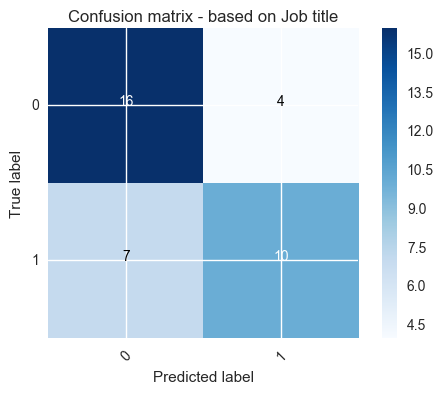

Accuracy: 0.702702702703
The classification report is as following:
             precision    recall  f1-score   support

          0       0.70      0.80      0.74        20
          1       0.71      0.59      0.65        17

avg / total       0.70      0.70      0.70        37



In [39]:
# We need first to transform categorical data into dummies variable so that to perform the logistic regression

dummies_jobtitle=pd.get_dummies(data["reshaped_jobtitle"])
study_2=pd.concat([data["salary_assesment"],dummies_jobtitle],axis=1)

# Let's define our predictor X which is the whole regions and our target wich is the salary assessment
X=study_2.iloc[:,1:]
y=study_2.iloc[:,0]

#Let's apply now a regression on a train test model
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.40, random_state=33)

logit=LogisticRegression(fit_intercept=True)
model=logit.fit(X_train,y_train)
prediction=model.predict(X_test)

conf=confusion_matrix(y_test,prediction)

plot_confusion_matrix(conf,model.classes_,title='Confusion matrix - based on Job title')


acc=accuracy_score(y_test,prediction)

print "Accuracy:", acc

clf_r=classification_report(y_test,prediction)
print "The classification report is as following:"
print clf_r

For the same sample we have a better accuracy.
Also I looked that time to the classification report, notably the precision and the recall.  
The precision represents the number of True  “high salary” predicted over “high salary” predicted. The recall represents the number of True “high salary” predicted over the number of true “high salary”.  
The report shows that recall is low and lower than the precision. It means that the model is conservative, we will more likely classify a job within the low salary category.  
At the next step we will use the cross_validation which will enable to compare our model in different packets of our sample. 

In [40]:
X=study_2.iloc[:,1:]
y=study_2.iloc[:,0]

logit=LogisticRegression(fit_intercept=True,random_state=33)

score=cross_val_score(logit,X,y,cv=3)

print "Accuracy:", score

Accuracy: [ 0.70967742  0.7         0.7       ]


The score for this model is about 0.7 for each validation. Even if it is better as the previous model, we can't consider the jobtitle as a unique good predictor as we mistaken 30% of the sample.
However it seems the salary depends on the job title and the location Let's have a look at the distribution for our sample.

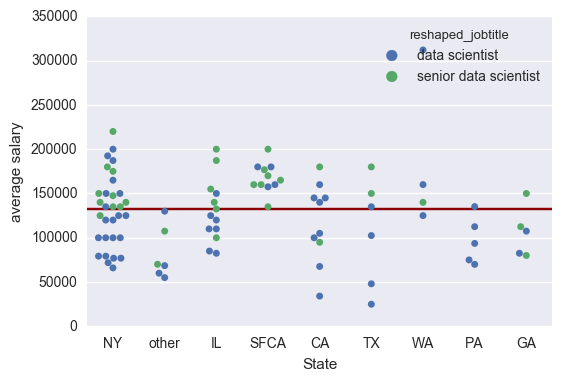

In [41]:
sns.swarmplot(x="State", y="average salary", hue="reshaped_jobtitle", data=data)
plt.axhline(np.median(data["average salary"]),c="Darkred")
sns.plt.show()

The Darkred horizontal line, representing the separation between categories high and "low" salary for data scientist, clearly points out that most of Senior Data Scientist job’s salary are above the median. Also, the Salary of Data Scientist vary depending on the city.

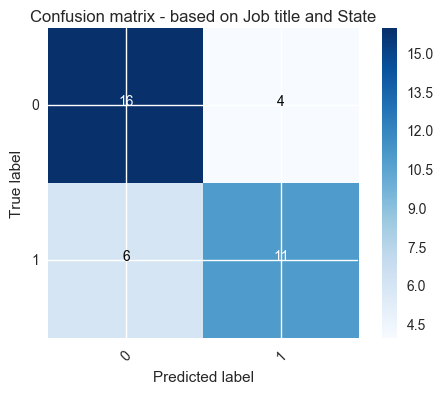

Accuracy: 0.72972972973
The classification report is as following:
             precision    recall  f1-score   support

          0       0.73      0.80      0.76        20
          1       0.73      0.65      0.69        17

avg / total       0.73      0.73      0.73        37



In [42]:
# Let look at how the logistic regression look likes.
# We need first to transform the categorical data into dummies variable so that to perform the logistic regression


study_3=pd.concat([data["salary_assesment"],dummies_jobtitle,dummies_state],axis=1)

# Let's define our predictor X which is the whole regions + job titles and our target wich is the salary assessment
X=study_3.iloc[:,1:]
y=study_3.iloc[:,0]

#Let's apply now a regression on a train test model
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.40, random_state=33)

logit=LogisticRegression(fit_intercept=True)
model=logit.fit(X_train,y_train)
prediction=model.predict(X_test)

conf=confusion_matrix(y_test,prediction)

plot_confusion_matrix(conf,model.classes_,title="Confusion matrix - based on Job title and State")


acc=accuracy_score(y_test,prediction)

print "Accuracy:", acc

clf_r=classification_report(y_test,prediction)
print "The classification report is as following:"
print clf_r

With the same sample, figures look a little bit better.  Let's confirm it with a cross validation

In [43]:
X=study_3.iloc[:,1:]
y=study_3.iloc[:,0]

logit=LogisticRegression(fit_intercept=True,random_state=33)

score=cross_val_score(logit,X,y,cv=3)

print "Acccuracy:", score

Acccuracy: [ 0.74193548  0.73333333  0.73333333]


As this is the best model of the three, let's use this predictor and try to improve the Logistic regression model not it.    
To that extent, we can adjust 2 p arameters:    
    * the regularisation term of the Loss function with a penalty equal to 'l1' or 'l2'( by default) norms, respectively corresponding to Lasso and Ridge regularisation. As a reminder this term added to the loss function permits to prevent from overfitting;  
    * the C score hyperparameters which fix the influence of the regularisation term. The smaller is the C the stronger is the regularisation term of our loss function.  
    
In order to quickly find the best fit, I am using the GridSearch function which will give the result based on a range of C and penalties.

In [44]:
from sklearn.model_selection import GridSearchCV

X=study_3.iloc[:,1:]
y=study_3.iloc[:,0]

#Let's apply now a regression on a train test model
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.40, random_state=33)

C_vals = [0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

logit=LogisticRegression(fit_intercept=True)
gs = GridSearchCV(logit,{'penalty':penalties,'C':C_vals},cv=3, verbose=True,scoring="accuracy")
gs.fit(X_train,y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    0.3s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

In [45]:
print "Best Accuracy score is:", gs.best_score_
print "Best parameters are",gs.best_params_
print "the best C coefficient is the default one however we will chose a Lasso regularization"

Best Accuracy score is: 0.759259259259
Best parameters are {'penalty': 'l1', 'C': 1.0}
the best C coefficient is the default one however we will chose a Lasso regularization


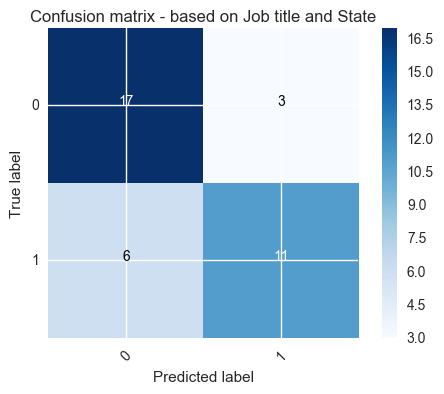

Accuracy: 0.756756756757
The classification report is as following:
             precision    recall  f1-score   support

          0       0.74      0.85      0.79        20
          1       0.79      0.65      0.71        17

avg / total       0.76      0.76      0.75        37



In [46]:
# Now we can apply penalty and C to our test set.

X=study_3.iloc[:,1:]
y=study_3.iloc[:,0]

#Let's apply now a regression on a train test model
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.40, random_state=33)

logit=LogisticRegression(C=1,penalty="l1",fit_intercept=True)
model=logit.fit(X_train,y_train)
prediction=model.predict(X_test)

conf=confusion_matrix(y_test,prediction)

plot_confusion_matrix(conf,model.classes_,title="Confusion matrix - based on Job title and State")


acc=accuracy_score(y_test,prediction)

print "Accuracy:", acc

clf_r=classification_report(y_test,prediction)
print "The classification report is as following:"
print clf_r


Even if the model got a better accuracy, we can still notice that it is staying too much conservative. A good way to visualise this, is by drawing the ROC curve.  
The ROC curve compares the true positive rate against the false positive rate. It is unaffected by the distribution of class labels since it only comparing the correct vs. incorrect label assignments for one class.

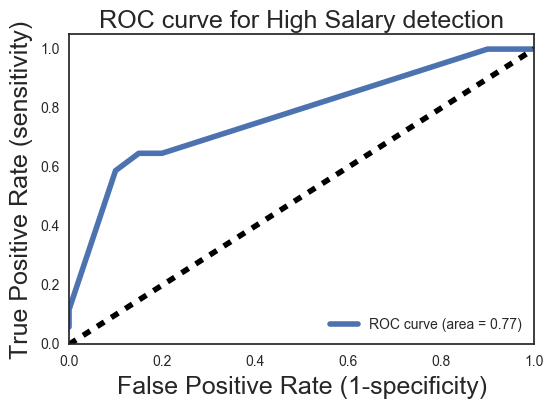

In [47]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline


Y_score = logit.decision_function(X_test)

# For class malignant, find the area under the curve
FPR, TPR, THR = roc_curve(y_test, Y_score)
ROC_AUC = auc(FPR, TPR)

# Plot of a ROC curve for class 1 (has_cancer)
#plt.figure(figsize=[11,9])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-specificity)', fontsize=18)
plt.ylabel('True Positive Rate (sensitivity)', fontsize=18)
plt.title('ROC curve for High Salary detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

The closiest to the diagonale the more conservative and less accurate is our model. An accurate model would be the one with a curve being tangent to the top left.


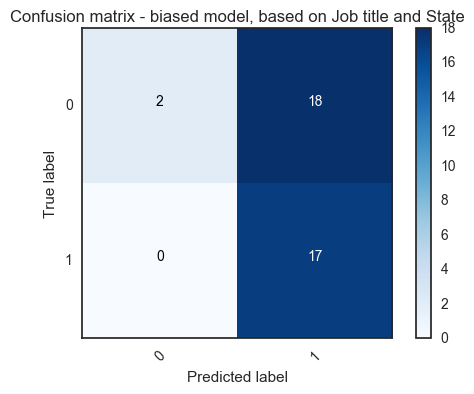

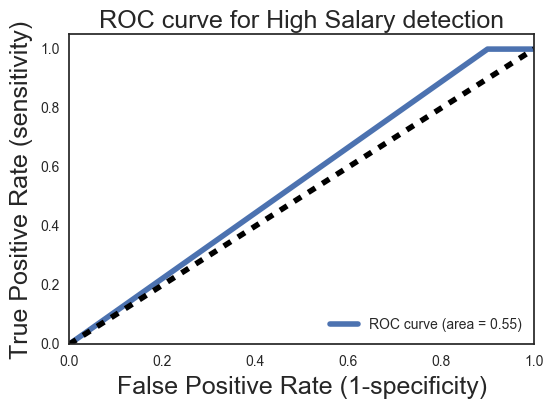

In [48]:
# As an example, even if our model is already conservative, we could want it to be even more and force the model to classify  more position as a low salary.
#This would apply in the case of a recruitment agency who would rather tell a client that
#he would get a lower salary for that job than tell a client incorrectly that they would get a high salary.

#To that extent I am creating a new vector Y_pp, that will return a high salary if the probability of getting salary is superior to 0,35. 

Y_pp = [0 if x[0]>0.65 else 1 for x in logit.predict_proba(X_test)]

conf=confusion_matrix(y_test,Y_pp)

plot_confusion_matrix(conf,model.classes_,title="Confusion matrix - biased model, based on Job title and State")


# For class , find the area under the curve
FPR, TPR, THR = roc_curve(y_test, Y_pp)
ROC_AUC = auc(FPR, TPR)

# Plot of a ROC curve for class 1 (has_cancer)
#plt.figure(figsize=[11,9])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-specificity)', fontsize=18)
plt.ylabel('True Positive Rate (sensitivity)', fontsize=18)
plt.title('ROC curve for High Salary detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

** Of course, it does not make sense here as the previous model was already not accurate enough!**

_In the following, I am trying to find a model not for a binary oupput but for 3 range of Salary for data scientist.
This would reflect more the reality._

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


## YOUR CODE HERE

data=pd.read_csv("indeed_with_sum.csv")
del data["Unnamed: 0"]
data.head()


,Company,Jobtitle,Location,Summary,average salary,reshaped_jobtitle,State
0,Scienaptic Systems Inc,Data Scientist,"New York, NY",\nWe are looking for an energetic and experien...,100000,data scientist,NY
1,POLICE DEPARTMENT,Data Analytics Research Scientist,"New York, NY","\nExtensive knowledge of applied statistics, a...",79249,data scientist,NY
2,Averity,Mid-level Data Scientist For Top Travel Company,"New York, NY",\nAre you a Mid-level Data Scientist looking t...,100000,data scientist,NY
3,DEPT OF ENVIRONMENT PROTECTION,City Research Scientist,"New York, NY","\nParticipating in data collection, analysis, ...",79249,data scientist,NY
4,Wade & Wendy,Wade & Wendy_Data Scientist/Engineer,"New York, NY",\nOur Data Scientist will integrate data from ...,100000,data scientist,NY


In [129]:

# As we saw in the swarm plot, we can create scale of salaries. In that case we will create 3 different ranges.

data["salary_assesment"]=pd.cut(data["average salary"],3)
data.head(10)

,Company,Jobtitle,Location,Summary,average salary,reshaped_jobtitle,State,salary_assesment
0,Scienaptic Systems Inc,Data Scientist,"New York, NY",\nWe are looking for an energetic and experien...,100000,data scientist,NY,"(26589.813, 101208.667]"
1,POLICE DEPARTMENT,Data Analytics Research Scientist,"New York, NY","\nExtensive knowledge of applied statistics, a...",79249,data scientist,NY,"(26589.813, 101208.667]"
2,Averity,Mid-level Data Scientist For Top Travel Company,"New York, NY",\nAre you a Mid-level Data Scientist looking t...,100000,data scientist,NY,"(26589.813, 101208.667]"
3,DEPT OF ENVIRONMENT PROTECTION,City Research Scientist,"New York, NY","\nParticipating in data collection, analysis, ...",79249,data scientist,NY,"(26589.813, 101208.667]"
4,Wade & Wendy,Wade & Wendy_Data Scientist/Engineer,"New York, NY",\nOur Data Scientist will integrate data from ...,100000,data scientist,NY,"(26589.813, 101208.667]"
5,Averity,Lead Data Scientist - Top Data Consultancy,"New York, NY",\nAre you a experienced Data Scientist who wan...,140000,senior data scientist,NY,"(101208.667, 175604.333]"
6,Averity,Lead Data Scientist (New Jersey),"New York, NY",\nWe are hiring a Lead Data Scientist for our ...,150000,senior data scientist,NY,"(101208.667, 175604.333]"
7,Selby Jennings,Senior Data Scientist,"New York, NY 10167 (Midtown area)",\nSenior Data Scientist. Data Intelligence Sof...,167500,senior data scientist,NY,"(101208.667, 175604.333]"
8,Princeton Consulting,Data Scientist,"New York, NY 10018 (Clinton area)","\nDigest complex data structures, perform stat...",192500,data scientist,NY,"(175604.333, 250000]"
9,Beeswax,Senior / Director Data Science,"New York, NY",\nA minimum of 5 years experience in Machine l...,147500,senior data scientist,NY,"(101208.667, 175604.333]"


In [130]:
# As we have states with few data, the future model of prediction can only predict random data. 
#Nevertheless, we can make the assumption they have the same cost of life, i.e same range of salary.

low_states=["AZ","OR","DE","CO","NJ"]

data["State"]=data["State"].apply(lambda x:"other" if x in low_states else x)

In [131]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.cross_validation import train_test_split,cross_val_predict,cross_val_score
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

In [132]:
dummies_jobtitle=pd.get_dummies(data["reshaped_jobtitle"])
dummies_state=pd.get_dummies(data["State"])

study_4=pd.concat([data["salary_assesment"],dummies_jobtitle,dummies_state],axis=1)

X=study_4.iloc[:,1:]
y=study_4.iloc[:,0]

In [133]:
from sklearn.model_selection import GridSearchCV

#Let's apply now a regression on a train test model
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.40, random_state=33)

C_vals = [0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

logit=LogisticRegression(fit_intercept=True)
gs = GridSearchCV(logit,{'penalty':penalties,'C':C_vals}, cv=3,verbose=True,scoring="accuracy")
gs.fit(X,y)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    0.4s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

In [134]:
print "Best Accuracy score is:", gs.best_score_
print "Best parameters are",gs.best_params_
print "the best C coefficient is the default one however we will chose a Lasso regularization"

Best Accuracy score is: 0.539325842697
Best parameters are {'penalty': 'l1', 'C': 0.0001}
the best C coefficient is the default one however we will chose a Lasso regularization


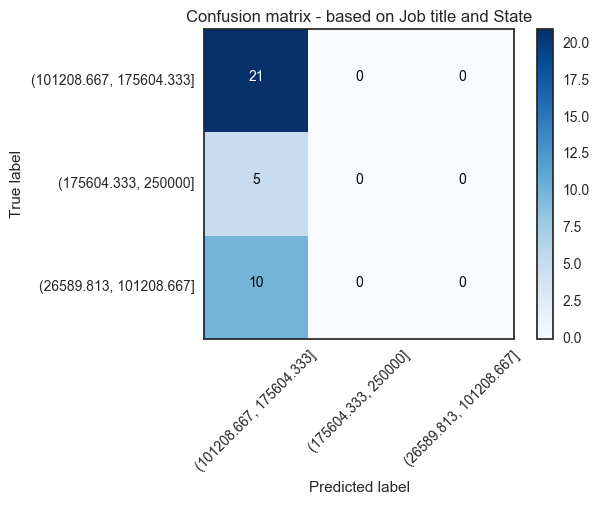

Accuracy: 0.583333333333
The classification report is as following:
                          precision    recall  f1-score   support

(101208.667, 175604.333]       0.58      1.00      0.74        21
    (175604.333, 250000]       0.00      0.00      0.00         5
 (26589.813, 101208.667]       0.00      0.00      0.00        10

             avg / total       0.34      0.58      0.43        36



In [135]:
# Now we can apply penalty and C to our test set.

#Let's apply now a regression on a train test model
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.40,random_state=33)

logit=LogisticRegression(C=0.0001,penalty="l1",fit_intercept=True)
model=logit.fit(X_train,y_train)
prediction=model.predict(X_test)

conf=confusion_matrix(y_test,prediction)

plot_confusion_matrix(conf,model.classes_,title="Confusion matrix - based on Job title and State")


acc=accuracy_score(y_test,prediction)

print "Accuracy:", acc

clf_r=classification_report(y_test,prediction)
print "The classification report is as following:"
print clf_r

We are lower than in accuracy compared to the binary output 

In [136]:
# let's introduce new precdictors such as the 50 words more commun in the job summary

from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(
    binary=True,  # Create binary features
    stop_words='english', # Ignore common words such as 'the', 'and'
    max_features=100, # Only use the top 50 most common words
)


# This builds a matrix with a row per website (or data point) and column per word (using all words in the dataset)
df_words = v.fit_transform(data.Summary).todense()
df_words = pd.DataFrame(df_words, columns=v.get_feature_names())
df_words.head()

,500,ability,advanced,algorithms,analysis,analytics,applications,applied,based,big,...,talented,team,technology,time,tools,using,work,working,world,years
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [137]:
study_5=pd.concat([data["salary_assesment"],dummies_jobtitle,dummies_state,df_words],axis=1)

X=study_5.iloc[:,1:]
y=study_5.iloc[:,0]

In [138]:
#Let's apply now a regression on a train test model
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.40, random_state=33)

C_vals = [0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

logit=LogisticRegression(fit_intercept=True)
gs = GridSearchCV(logit,{'penalty':penalties,'C':C_vals},cv=3, verbose=True,scoring="accuracy")
gs.fit(X,y)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    0.4s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

In [139]:
print "Best Accuracy score is:", gs.best_score_
print "Best parameters are",gs.best_params_
print "the best C coefficient is the default one however we will chose a Lasso regularization"

Best Accuracy score is: 0.561797752809
Best parameters are {'penalty': 'l2', 'C': 0.1}
the best C coefficient is the default one however we will chose a Lasso regularization


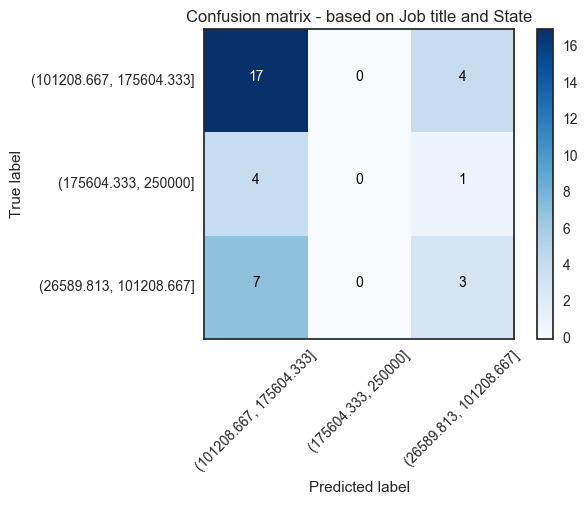

Accuracy: 0.555555555556
The classification report is as following:
                          precision    recall  f1-score   support

(101208.667, 175604.333]       0.61      0.81      0.69        21
    (175604.333, 250000]       0.00      0.00      0.00         5
 (26589.813, 101208.667]       0.38      0.30      0.33        10

             avg / total       0.46      0.56      0.50        36



In [141]:
# Now we can apply penalty and C to our test set.

#Let's apply now a regression on a train test model
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.40, random_state=33)

logit=LogisticRegression(C=0.1,penalty="l2",fit_intercept=True)
model=logit.fit(X_train,y_train)
prediction=model.predict(X_test)

conf=confusion_matrix(y_test,prediction)

plot_confusion_matrix(conf,model.classes_,title="Confusion matrix - based on Job title and State")


acc=accuracy_score(y_test,prediction)

print "Accuracy:", acc

clf_r=classification_report(y_test,prediction)
print "The classification report is as following:"
print clf_r

_**Conclusion for the study of salary classification in function of Job title and Location**_

For a salary classification to high or low, a good model could probably reach an accuracy of more than 90%.
The fact that our model is too conservative can, in addition to the size of the sample, come from data scientist in some cities earning more than Senior data scientist in others, probably due to different sectors of application.
How to remedy to this:  
	* To go further into improving our model, one way is to create a new predictors such as the content of company description instead of job description. A work in a university pay less (see table below) or at contrary into a Financial company.

In [49]:
data.loc[data["Company"].str.contains("University"),:]

,Company,Jobtitle,Location,average salary,reshaped_jobtitle,State,salary_assesment
55,University of California Berkeley,"Research Data Analyst, CalSWEC","Berkeley, CA",67589,data scientist,CA,0
85,University of Texas at Dallas,Research Scientist,"Richardson, TX",48000,data scientist,TX,0
87,Portland State University,Research Data Analyst,"Portland, OR",60000,data scientist,other,0
89,Arizona State University,ASSISTANT RESEARCH SCIENTIST,"Tempe, AZ",55000,data scientist,other,0
